# Exercise 05.1

The wave function of an electron in a Hydrogen atom can be expressed in spherical coordinates (so that it can be separated into functions of each coordinate):

$$
\Psi_{n,l,m}(r,\theta,\phi)=
\sqrt{\left(\frac{2}{na_0}\right)^3 \frac{(n-l-1)!}{2n[(n+l)!]}}
e^{-r/na_0}\left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\left(\frac{2r}{na_0}\right)
Y_l^m(\theta,\phi)
$$

Where $a_0$ is the Bohr radius:
$$ a_0 = \frac{4 \pi \epsilon_0 \hbar^2}{m_e e^2} = 0.0529 \, \mathrm{nm} $$

The ground state wave function is:
$$ Y_{1,0,0}\left( r, \theta, \phi \right) = \frac{1}{\sqrt{\pi a_0^3}} e^{-r/a_0} $$
The wave function for the state $ |2,1,0\rangle $ (one of the $2p$ states) is:
$$ Y_{2,1,0}\left( r, \theta, \phi \right) = \frac{1}{8} \sqrt{\frac{2}{\pi a_0^5}} r e^{-r/\left(2 a_0\right)} \cos\left(\theta\right)$$

In [1]:
import matplotlib
import scipy
from scipy import constants as cst
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import subprocess
import scipy.stats as stats

titleSize = 20
axesLabelSize = 15

In [2]:
def a_0():
    return (4*cst.pi*cst.epsilon_0*(cst.hbar**2))/(cst.m_e*(cst.e**2))

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)
    
def set_initial_conditions(stepNumber, samplingType, state, stepEquilibrium):
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define numberOfSteps .*.$/#define numberOfSteps '+str(stepNumber)+'/" metropolis.h'])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define samplingType .*.$/#define samplingType '+samplingType+'/" metropolis.h'])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define state .*.$/#define state '+state+'/" metropolis.h'])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define equilibriumSteps .*.$/#define equilibriumSteps '+str(stepEquilibrium)+'/" metropolis.h'])
 
def compile_simulation():
    subprocess.check_output(["/bin/sh", "-c", "make clean"])
    subprocess.check_output(["/bin/sh", "-c", "make"])

def run_simulation(x, y, z):
    print(subprocess.check_output(["/bin/sh", "-c", "./main.exe "+str(x)+" "+str(y)+" "+str(z)]).decode('utf-8'))
    
def move_output_file(destinationDirectory, samplingType):
    subprocess.check_output(["/bin/sh", "-c", "cp final_configuration.txt "+destinationDirectory+"/final_configuration_"+samplingType+".txt"])

a0 = a_0()

In this exercise I used the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ in Cartesian coordinates.  
The expectation values are
$$ \langle r \rangle_{1,0,0} = \frac{3}{2}a_0 $$
and
$$ \langle r \rangle_{2,1,0} = 5 a_0 $$

In [3]:
def radial_plot(stepNumber, samplingType, state, expectedValue):
    
    array = np.zeros(stepNumber)
    
    i = 0
    with open(state+'/final_configuration_'+samplingType+'.txt') as reader:
        for line in reader:
            x = float((line.split())[0])
            y = float((line.split())[1])
            z = float((line.split())[2])
            array[i] = np.sqrt(x*x + y*y + z*z)
            i += 1
    
    
    print(stepNumber, 'numbers generated')
    numberOfBlocks = 100
    numbersPerBlock = int(stepNumber/numberOfBlocks)
    print(numberOfBlocks, 'blocks')
    print(numbersPerBlock, 'numbers generated per block')

    if numbersPerBlock * numberOfBlocks != stepNumber:
        print('Warning! numbersGenerated is not a multiple of numberOfBlocks')
    
    r = np.arange(numberOfBlocks)
    ave = np.zeros(numberOfBlocks)
    av2 = np.zeros(numberOfBlocks)
    sum_prog = np.zeros(numberOfBlocks)
    su2_prog = np.zeros(numberOfBlocks)
    err_prog = np.zeros(numberOfBlocks)
    reference = np.zeros(numberOfBlocks)


    for i in range(numberOfBlocks):
        sum = 0
        for j in range(numbersPerBlock):
            sum += array[j + i * numbersPerBlock]
        ave[i] = sum / numbersPerBlock
        av2[i] = (ave[i])**2


    for i in range(numberOfBlocks):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
    
    plt.figure(figsize=(12, 12))
    plt.title(state+' State ('+samplingType+' sampling)', fontsize=titleSize)
    plt.errorbar(r+1, sum_prog - expectedValue, yerr=err_prog, label='Wave function - '+str(expectedValue))
    plt.errorbar(r+1, reference, fmt='--', label='Expected')
    plt.legend(loc='best')
    plt.xlabel('#Blocks', fontsize=axesLabelSize)
    plt.ylabel('$\Psi(r,\\theta,\phi) - $'+str(expectedValue), fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()

In [4]:
def block_plot(stepNumber, samplingType, state, expectedValue):
    
    array = np.zeros(stepNumber)
    
    i = 0
    xold = 0
    yold = 0
    zold = 0
    accepted = np.zeros(stepNumber)
    with open(state+'/final_configuration_'+samplingType+'.txt') as reader:
        for line in reader:
            x = float((line.split())[0])
            y = float((line.split())[1])
            z = float((line.split())[2])
            if (xold == x and yold == y and zold == z):
                accepted[i] = 1
            xold = x
            yold = y
            zold = z
            array[i] = np.sqrt(x*x + y*y + z*z)
            i += 1
    
    arrayOfSteps = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 
                    500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 
                    1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3500, 4000, 4500, 5000, 5500,
                    6000, 6500, 7000, 8000, 9000, 10000]
    minimum = np.zeros(len(arrayOfSteps))
    maximum = np.zeros(len(arrayOfSteps))
    average = np.zeros(len(arrayOfSteps))
    for k in range(len(arrayOfSteps)):
        minimum[k] = 2
        maximum[k] = -1
        for i in range(int(stepNumber/arrayOfSteps[k])):
            counter = 0
            for j in range(arrayOfSteps[k]):
                counter += accepted[i*arrayOfSteps[k]+j]
            if counter/arrayOfSteps[k] > maximum[k]:
                maximum[k] = counter/arrayOfSteps[k]
            if counter/arrayOfSteps[k] < minimum[k]:
                minimum[k] = counter/arrayOfSteps[k]
            average[k] += counter/arrayOfSteps[k]
        average[k] /= (int(stepNumber/arrayOfSteps[k]))
        
    plt.figure(figsize=(12, 12))
    plt.title(state+' State acceptance rate ('+samplingType+' sampling)', fontsize=titleSize)
    plt.plot(arrayOfSteps, minimum, label='Minimum')
    plt.plot(arrayOfSteps, maximum, label='Maximum')
    plt.plot(arrayOfSteps, average, '--', label='Average')
    plt.legend(loc='best')
    plt.xlabel('#Steps per block', fontsize=axesLabelSize)
    plt.ylabel('Acceptance rate', fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()

In [5]:
def scatter_plot(stepNumber, samplingType, state, expectedValue):
    
    x = []
    y = []
    z = []
    with open(state+'/final_configuration_'+samplingType+'.txt') as reader:
        for line in reader:
            x.append(float((line.split())[0]))
            y.append(float((line.split())[1]))
            z.append(float((line.split())[2]))
    
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=z, marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(10, 30)
    plt.show()

In [6]:
def simulation(stepNumber, samplingType, state, expectedValue, position, equilibriumSteps):
    set_initial_conditions(stepNumber, samplingType, state, equilibriumSteps)
    compile_simulation()
    run_simulation(position[0], position[1], position[2])
    move_output_file(state, samplingType)
    radial_plot(stepNumber, samplingType, state, expectedValue)    

In [7]:
def new_simulation(stepNumber, samplingType, state, expectedValue, position, equilibriumSteps):
    set_initial_conditions(stepNumber, samplingType, state, equilibriumSteps)
    compile_simulation()
    run_simulation(position[0], position[1], position[2])
    move_output_file(state, samplingType)
    block_plot(stepNumber, samplingType, state, expectedValue)

In [8]:
def scatter_simulation(stepNumber, samplingType, state, expectedValue, position, equilibriumSteps):
    set_initial_conditions(stepNumber, samplingType, state, equilibriumSteps)
    compile_simulation()
    run_simulation(position[0], position[1], position[2])
    move_output_file(state, samplingType)
    scatter_plot(stepNumber, samplingType, state, expectedValue)

I implemented the Metropolis algorithm in a C++ program (```metropolis.cpp``` and ```metropolis.h```).
First of all, I try to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ from a uniform transition probability $ T(\vec{y} | \vec{x}) $.  
To improve the efficiency of the algorithm it is important that the acceptance rate close to 50%.
The proposed coordinate is $ y = x + (\eta - 0.5) * \sigma$, where $\eta$ is a random number sampled from a uniform propability in the range $[0,1]$.  
The values of sigma that let us obtain an acceptance rate close to 50% are:
 - $ \sigma = 2.4 $ for the state $ |1,0,0\rangle $;
 - $ \sigma = 5.8 $ for the state $ |2,1,0\rangle $.  
 
We start the simulation from:
 1. $(0,0,0)$;
 2. $(100,100,100)$.
The results are expressed in units of $a_0$.

In [9]:
samplings = ['UNIFORM', 'GAUSSIAN']
states = ['GROUND', 'EXCITED']
results = [1.5, 5.0]

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.506905

1000000 numbers generated
100 blocks
10000 numbers generated per block


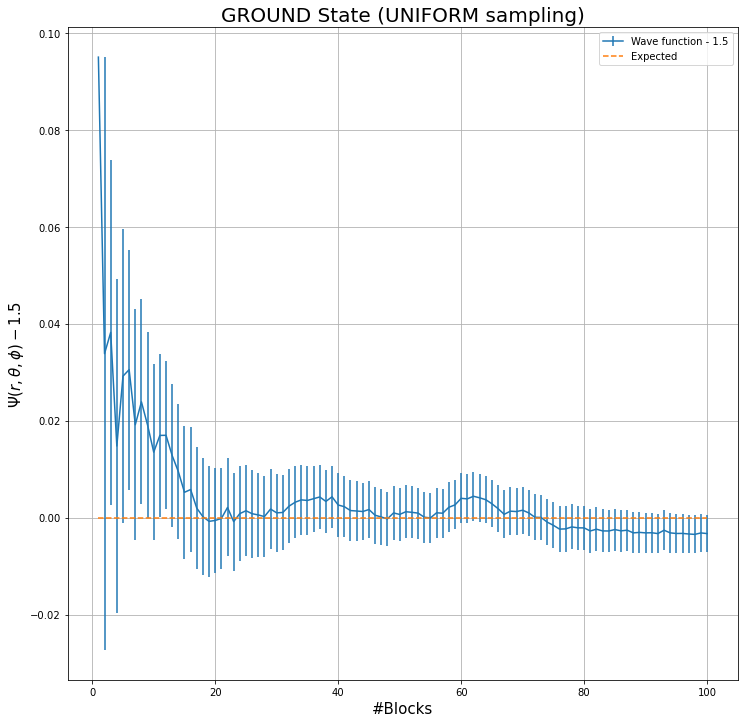

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.510063

1000000 numbers generated
100 blocks
10000 numbers generated per block


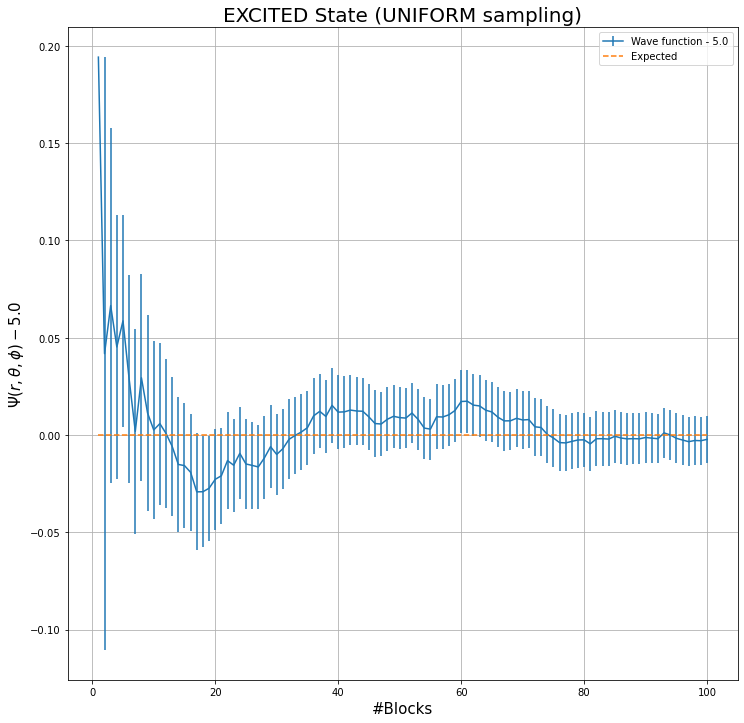

|1,0,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.507304

1000000 numbers generated
100 blocks
10000 numbers generated per block


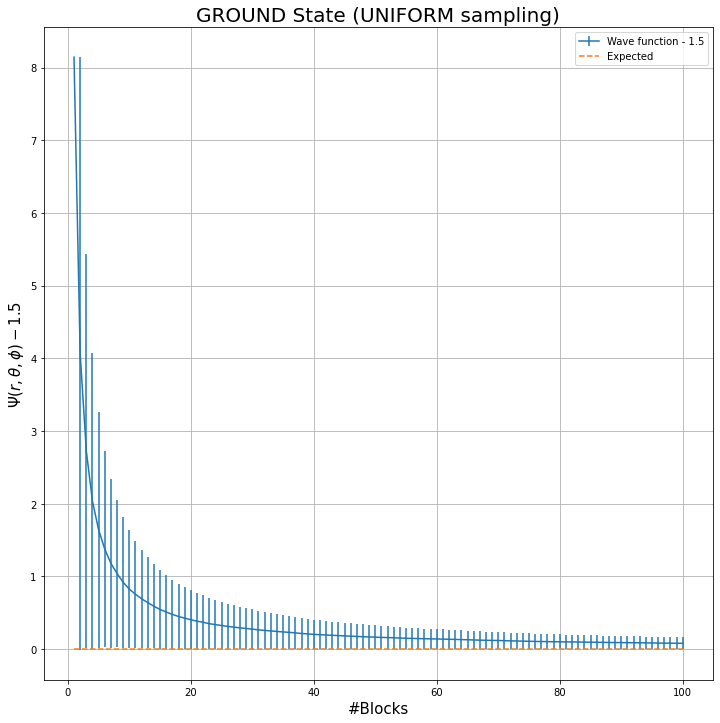

|2,1,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.509755

1000000 numbers generated
100 blocks
10000 numbers generated per block


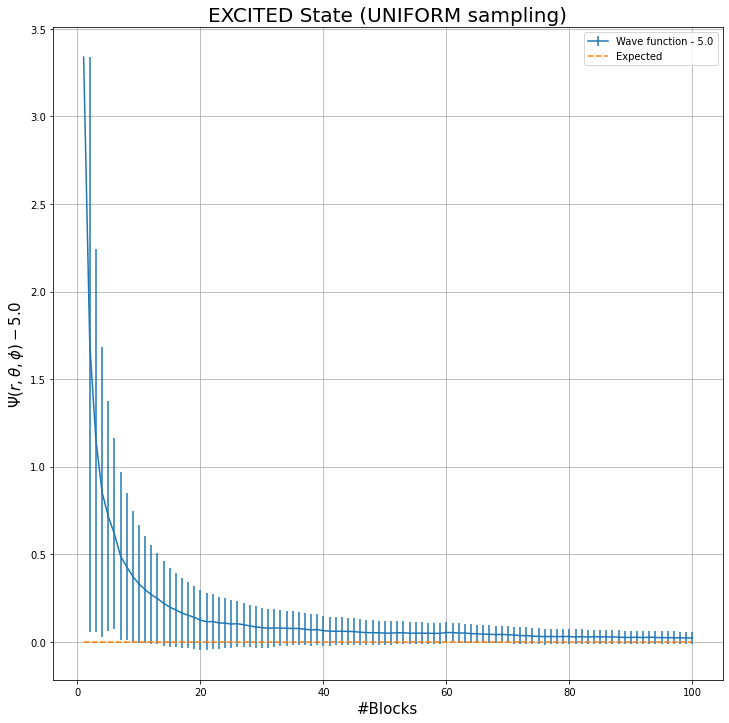

In [81]:
# (1)

startingPosition = [0,0,0]
for i in range(len(states)):
    simulation(1000000, samplings[0], states[i], results[i], startingPosition, 0)
    
# (2)
    
startingPosition = [100,100,100]
for i in range(len(states)):
    simulation(1000000, samplings[0], states[i], results[i], startingPosition, 0)

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.507308



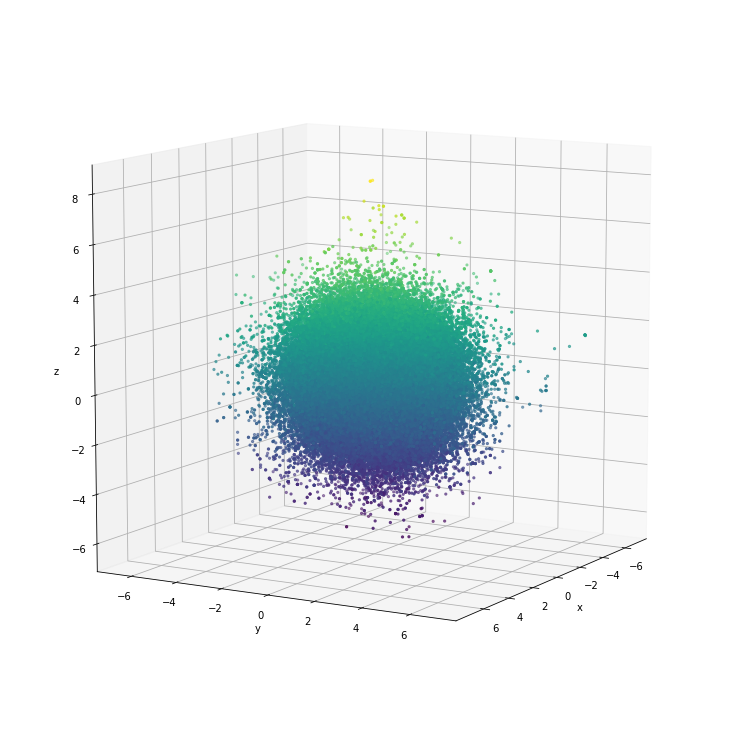

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.510243



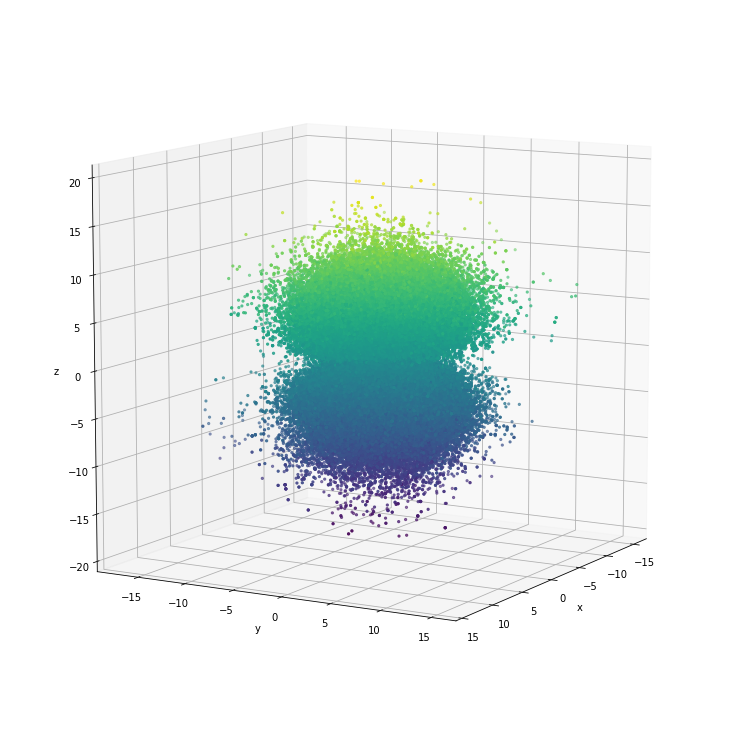

|1,0,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.507913



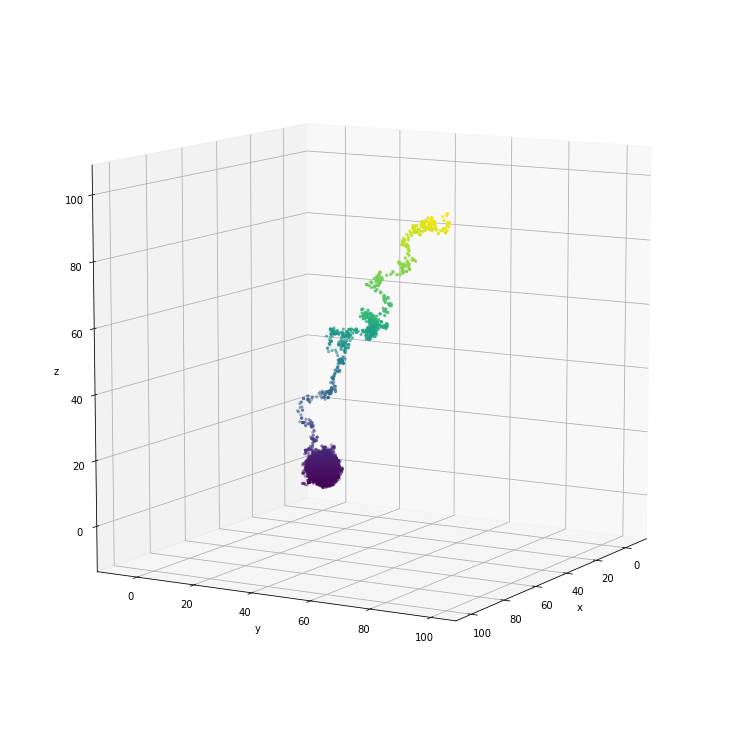

|2,1,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.510517



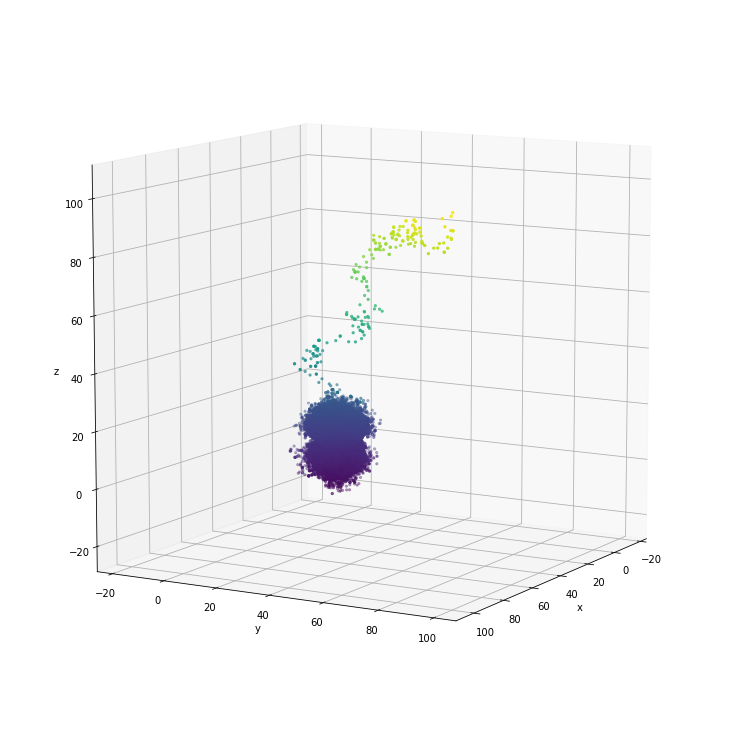

In [72]:
startingPosition = [0,0,0]

for i in range(len(states)):
    scatter_simulation(600000, samplings[0], states[i], results[i], startingPosition, 80000)
startingPosition = [100,100,100]
for i in range(len(states)):
    scatter_simulation(600000, samplings[0], states[i], results[i], startingPosition, 0)

How large should be the number of Monte Carlo Metropolis steps in each block?  
I tried to show in a picture the maximum and minimum acceptance rates as a function of the number of steps per block.  
Ideally we want the acceptance rate to be as close as possible to 0.5.

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.506918



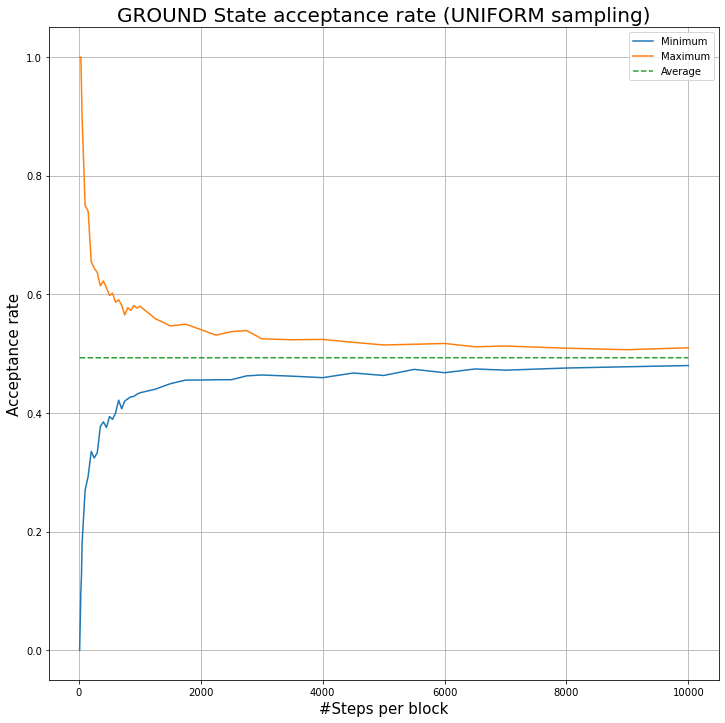

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.510282



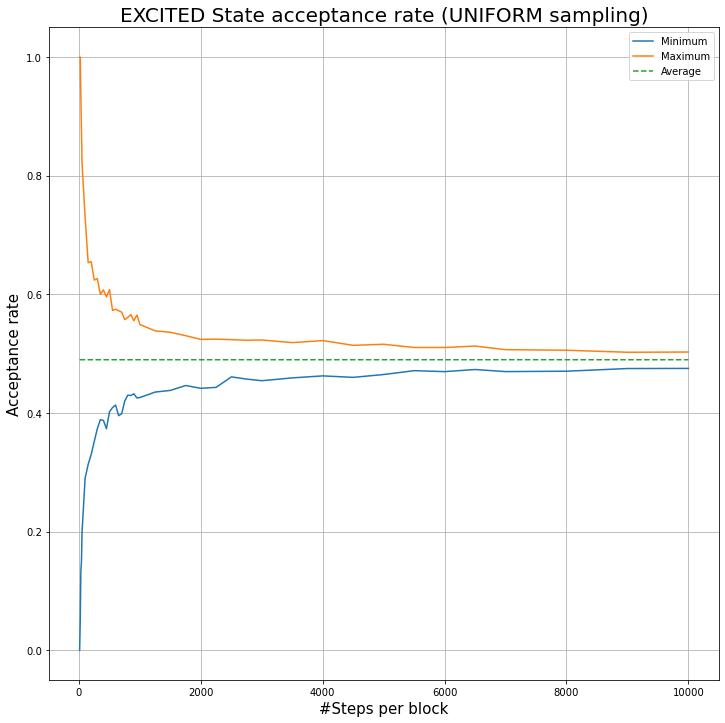

In [28]:
startingPosition = [0,0,0]
for i in range(len(states)):
    new_simulation(1000000, samplings[0], states[i], results[i], startingPosition, 80000)

In both cases, with about 6000 steps per block both the minimum and maximum acceptance rates are very close to 0.5

We should also take into account autocorrelation between our data. We want each block to be uncorrelated with its neighbours.

In [15]:
def autocorrelation_correct(tau, array, length):
    if tau > length:
        return 0
    sum = np.zeros(5)
    norm = [length-tau, length-tau, length-tau, length, length]
    
    for i in range(length - tau):
        sum[0] += array[i]
        sum[1] += array[i + tau]
        sum[2] += array[i] * array[i + tau]
    for i in range(length):
        sum[3] += array[i]
        sum[4] += array[i]**2
    for i in range(5):
        sum[i] /= norm[i]
    return (sum[2] - sum[0] * sum[1]) / (sum[4] - sum[3]**2)

def autocorrelation(tau, array, length):
    if tau > length:
        return 0
    sum = np.zeros(5)
    
    for i in range(length - tau):
        sum[0] += array[i]
        sum[1] += array[i + tau]
        sum[2] += array[i] * array[i + tau]
        sum[3] += array[i]**2
        sum[4] += array[i + tau]**2
    for i in range(5):
        sum[i] /= (length - tau)
    return (sum[2] - sum[0] * sum[1]) / np.sqrt((sum[3] - sum[0]**2) * (sum[4] - sum[1]**2))

def correlation_plot(stepNumber, samplingType, state, expectedValue, correlationSize):
    
    array = np.zeros(stepNumber)
    correlationPotential = np.zeros(correlationSize)
    plt.figure(figsize=(10, 10))
    plt.title('Position autocorrelation ('+str(state)+' state)', fontsize=titleSize)
    for j in range(3):
        i = 0
        X = np.arange(correlationSize)
        with open(state+'/final_configuration_'+samplingType+'.txt') as reader:
            for line in reader:
                x = float((line.split())[j])
                
                array[i] = x
                i += 1
    
        for i in range(correlationSize):
            correlationPotential[i] = autocorrelation_correct(i, array, len(array))
        plt.plot(X, correlationPotential, label=positionLabels[j])
    plt.legend()
    plt.xlabel('$\\tau$', fontsize=axesLabelSize)
    plt.ylabel('$x$', fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()
    
def correlation_simulation(stepNumber, samplingType, state, expectedValue, position, equilibriumSteps, correlationSize):
    set_initial_conditions(stepNumber, samplingType, state, equilibriumSteps)
    compile_simulation()
    run_simulation(position[0], position[1], position[2])
    move_output_file(state, samplingType)
    correlation_plot(stepNumber, samplingType, state, expectedValue, correlationSize)
  

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.506918



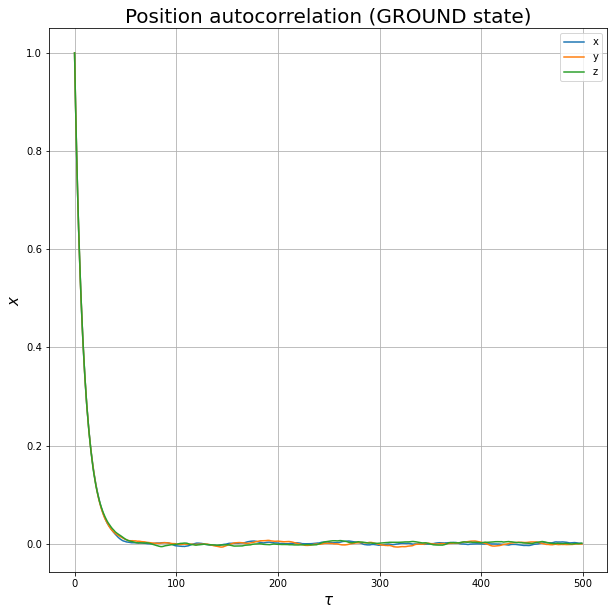

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.510282



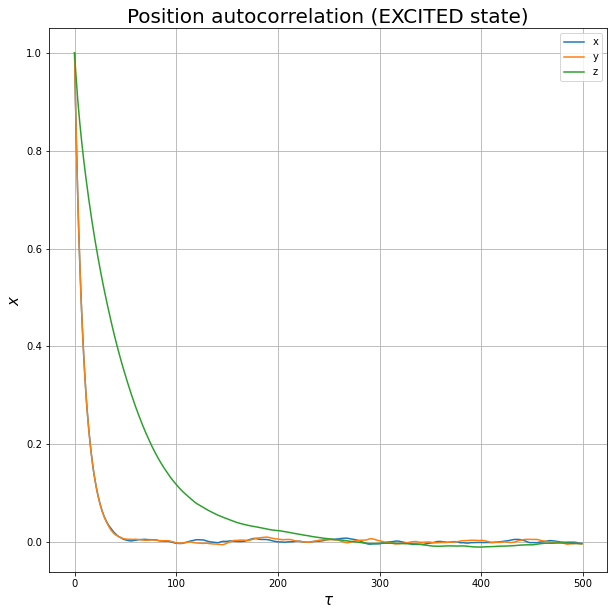

In [16]:
positionLabels = ['x', 'y', 'z']
autocorrelationSize = 500
startingPosition = [0,0,0]
for i in range(len(states)):
    correlation_simulation(1000000, samplings[0], states[i], results[i], startingPosition, 80000, autocorrelationSize)

We can see that after 200 steps the autocorrelation drops to almost zero.

This time I equilibrated the simulation for $8 \cdot 10^4$ steps.  
$ 6 \cdot 10^3 $ Metropolis steps per block.

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.507308

600000 numbers generated
100 blocks
6000 numbers generated per block


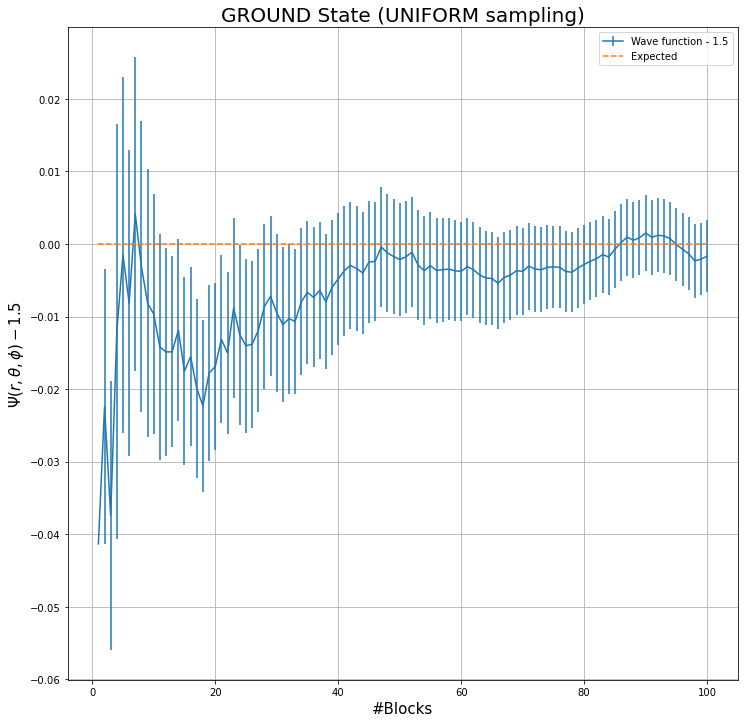

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.510243

600000 numbers generated
100 blocks
6000 numbers generated per block


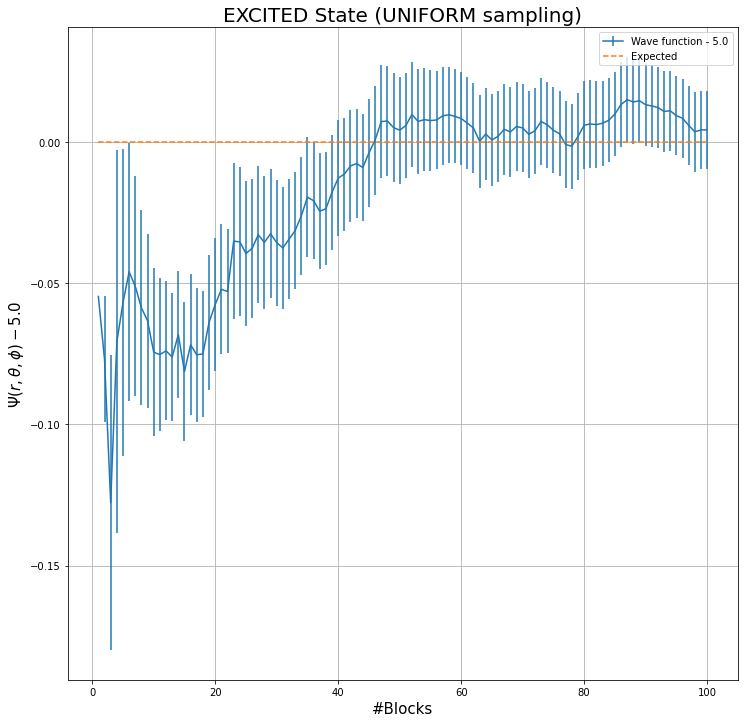

|1,0,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.507567

600000 numbers generated
100 blocks
6000 numbers generated per block


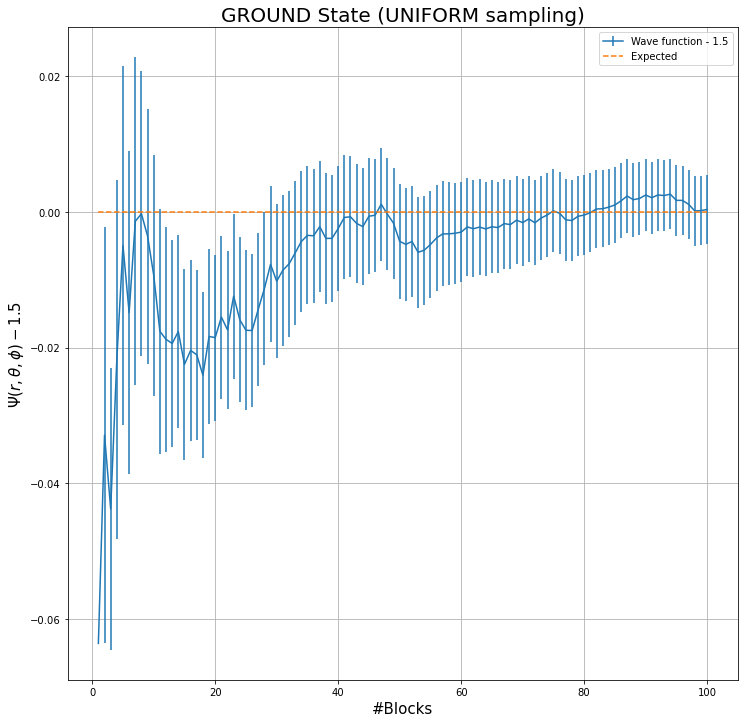

|2,1,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.50974

600000 numbers generated
100 blocks
6000 numbers generated per block


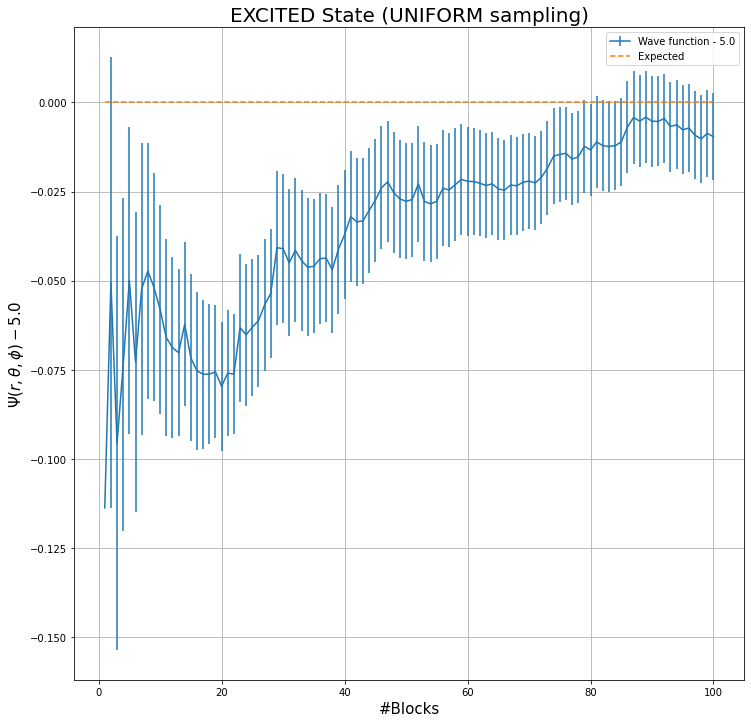

In [77]:
# (1)

startingPosition = [0,0,0]
for i in range(len(states)):
    simulation(6000*100, samplings[0], states[i], results[i], startingPosition, 80000)
    
# (2)
    
startingPosition = [100,100,100]
for i in range(len(states)):
    simulation(6000*100, samplings[0], states[i], results[i], startingPosition, 80000)

The results are close to the expected values, even if starting from far away from $ \langle r \rangle $.

Finally I changed the transition probability.  
I've chosen $ T( \vec{y} | \vec{x} ) $ to be a multivatiate gaussian.
$$ T( y_i | x_i ) = \mathcal{N}(x_i, \sigma) $$
This transition probability is symmetric:

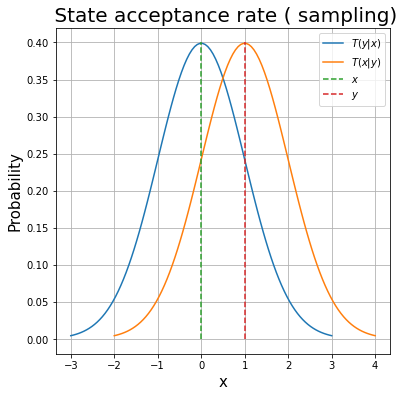

In [100]:
x0 = 0
y0 = 1
z = np.linspace(0,0.4,100)
w = np.zeros(100)
x = np.linspace(x0 - 3, x0 + 3, 100)
y = np.linspace(y0 - 3, y0 + 3, 100)
plt.figure(figsize=(6, 6))
plt.title(' State acceptance rate ( sampling)', fontsize=titleSize)
plt.plot(x, stats.norm.pdf(x, x0, 1), label='$T(y|x)$')
plt.plot(y, stats.norm.pdf(y, y0, 1), label='$T(x|y)$')
plt.plot(w+x0, z, '--', label='$x$')
plt.plot(w+y0, z, '--', label='$y$')
plt.legend(loc='best')
plt.xlabel('x', fontsize=axesLabelSize)
plt.ylabel('Probability', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

The acceptance rate is thus $ A( \vec{y}, \vec{x}) = \min \left( 1, \frac{p(y)}{p(x)} \right)$.

I will repeat now the same steps done before with the new transition probability.

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.504363

1000000 numbers generated
100 blocks
10000 numbers generated per block


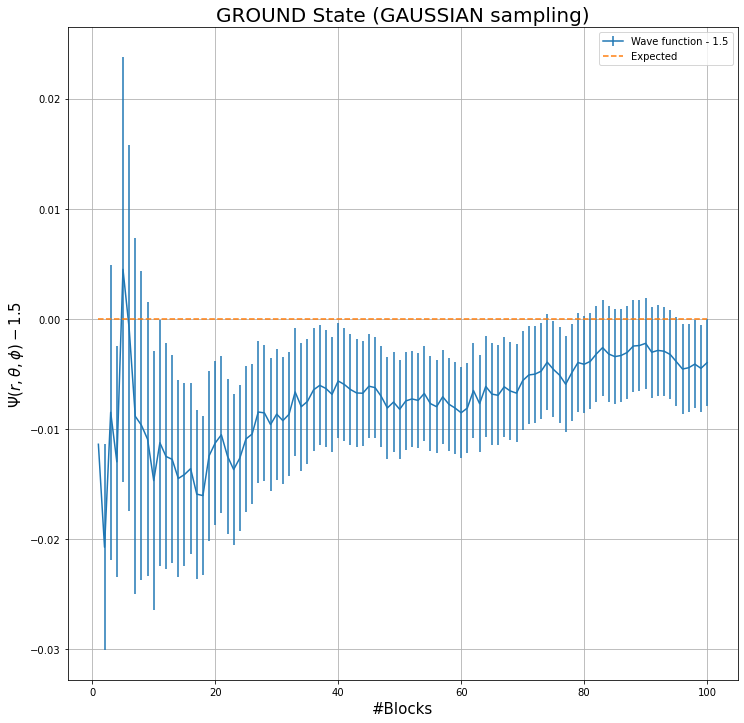

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.514691

1000000 numbers generated
100 blocks
10000 numbers generated per block


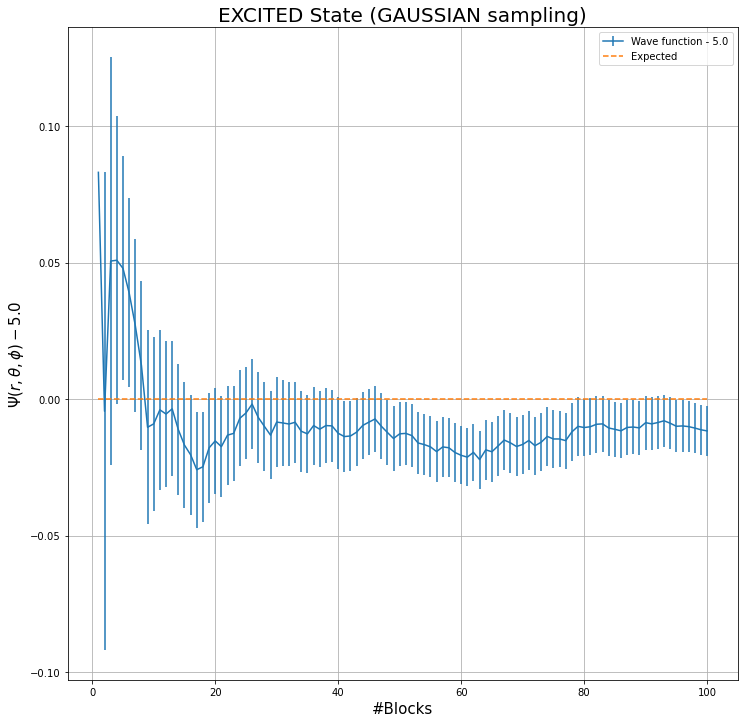

|1,0,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.504882

1000000 numbers generated
100 blocks
10000 numbers generated per block


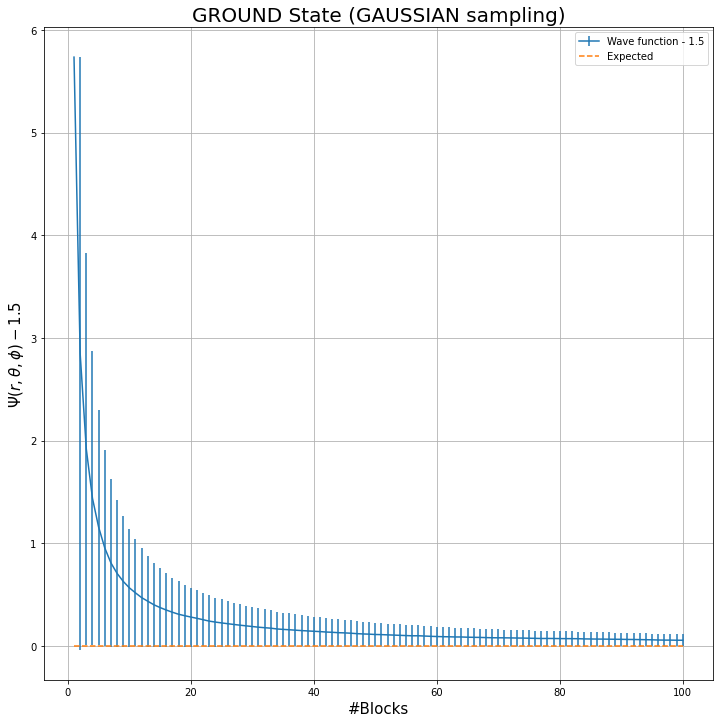

|2,1,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.515898

1000000 numbers generated
100 blocks
10000 numbers generated per block


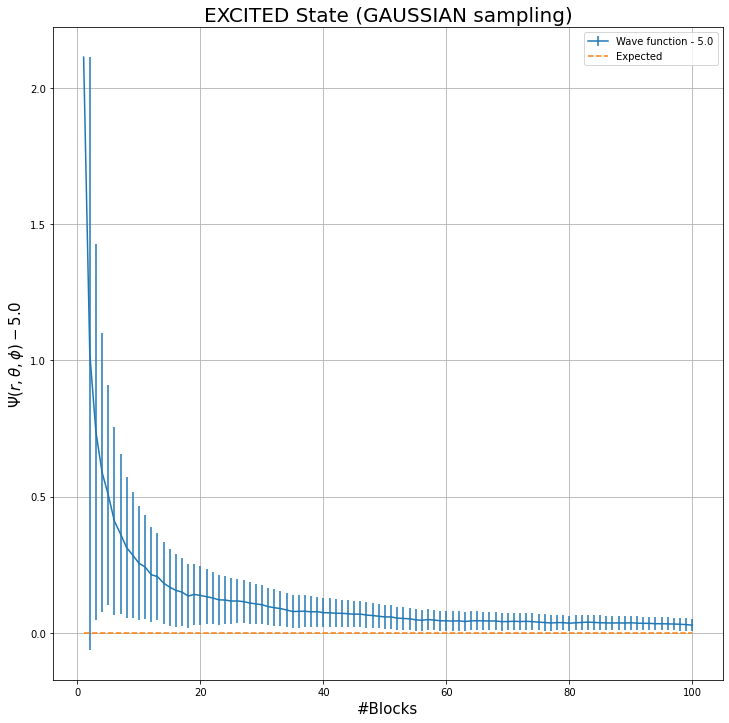

In [94]:
# (1)

startingPosition = [0,0,0]
for i in range(len(states)):
    simulation(1000000, samplings[1], states[i], results[i], startingPosition, 0)
    
# (2)
    
startingPosition = [100,100,100]
for i in range(len(states)):
    simulation(1000000, samplings[1], states[i], results[i], startingPosition, 0)

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.504537



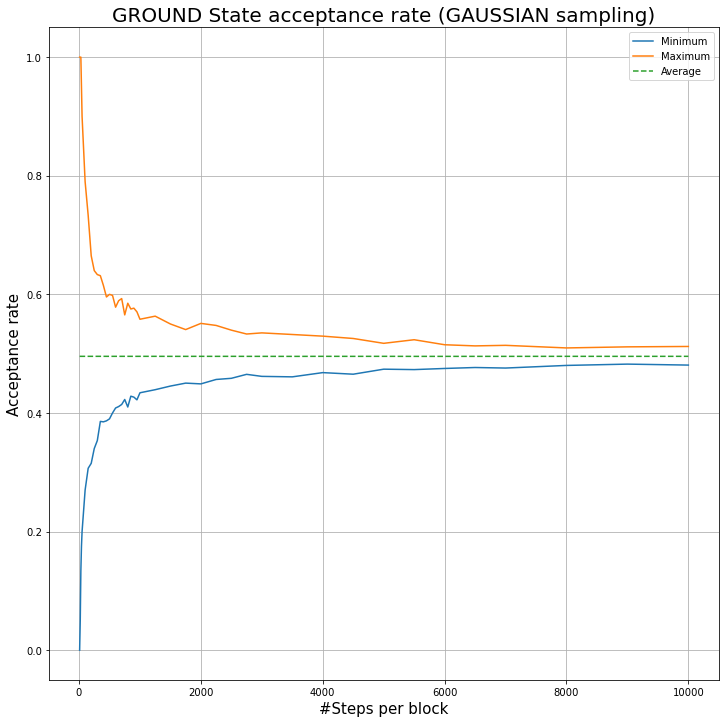

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.514266



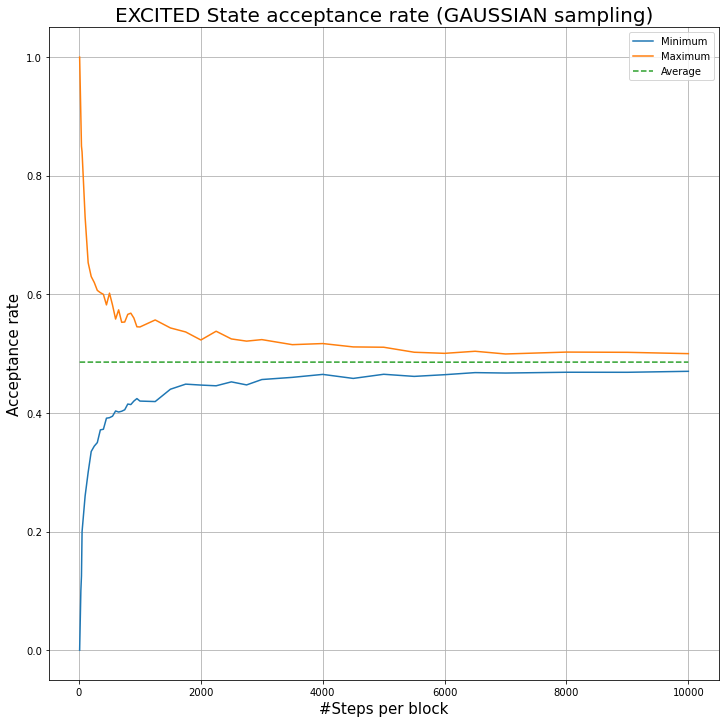

In [95]:
startingPosition = [0,0,0]
for i in range(len(states)):
    new_simulation(1000000, samplings[1], states[i], results[i], startingPosition, 80000)

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.504537



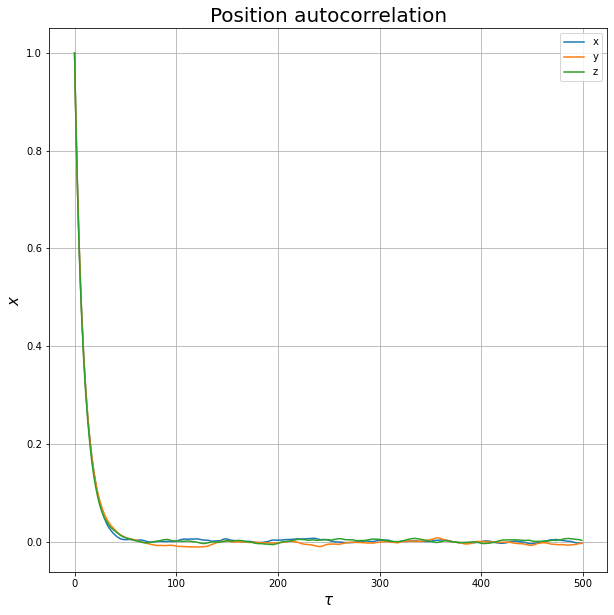

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.514266



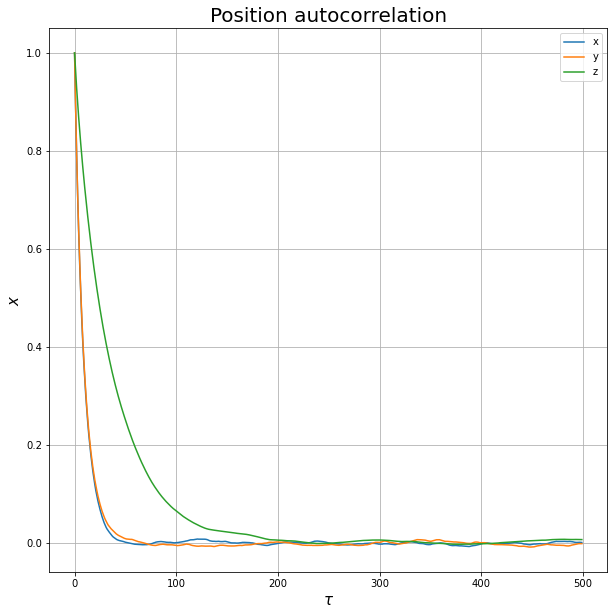

In [14]:
positionLabels = ['x', 'y', 'z']
autocorrelationSize = 500
startingPosition = [0,0,0]
for i in range(len(states)):
    correlation_simulation(1000000, samplings[1], states[i], results[i], startingPosition, 80000, autocorrelationSize)

|1,0,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.50446

800000 numbers generated
100 blocks
8000 numbers generated per block


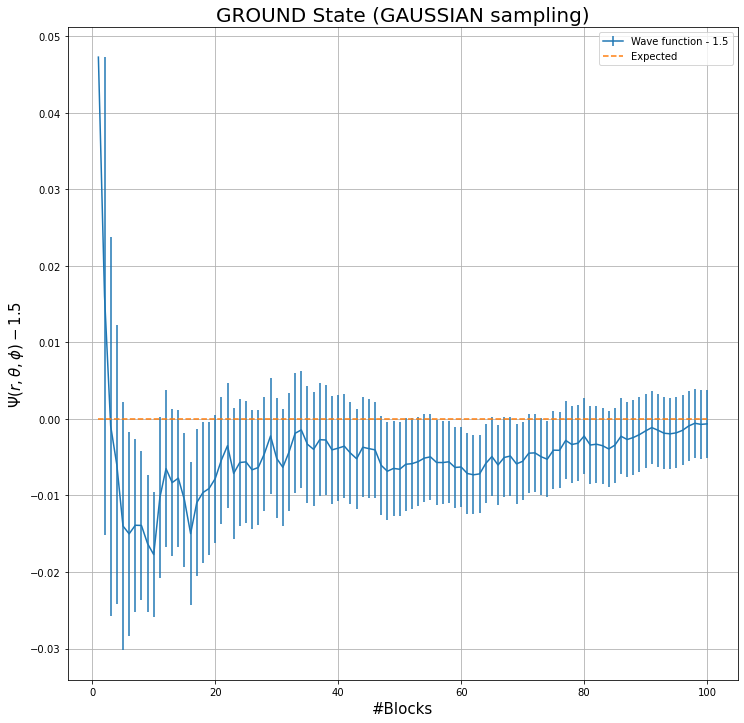

|2,1,0>
Setting starting point to (0, 0, 0)
Acceptance rate: 0.514687

800000 numbers generated
100 blocks
8000 numbers generated per block


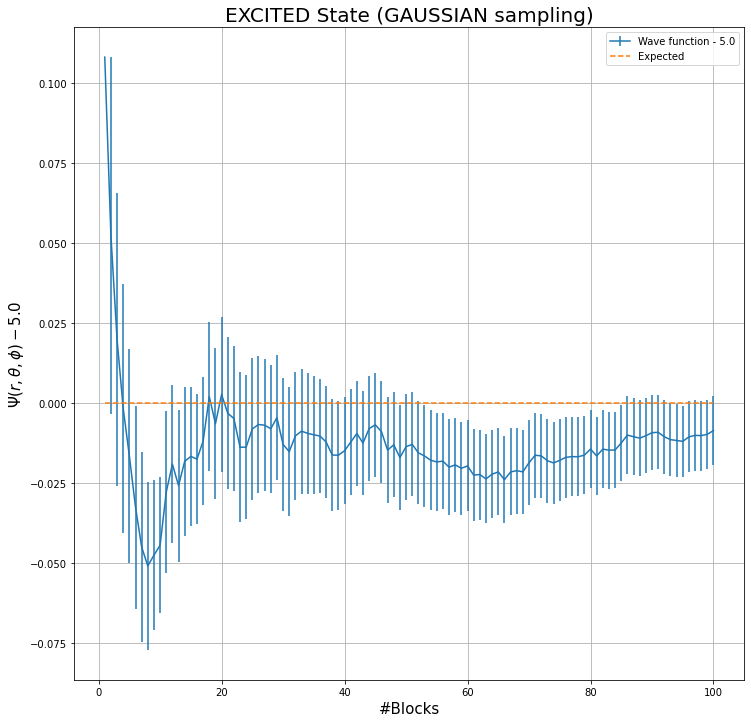

|1,0,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.505145

800000 numbers generated
100 blocks
8000 numbers generated per block


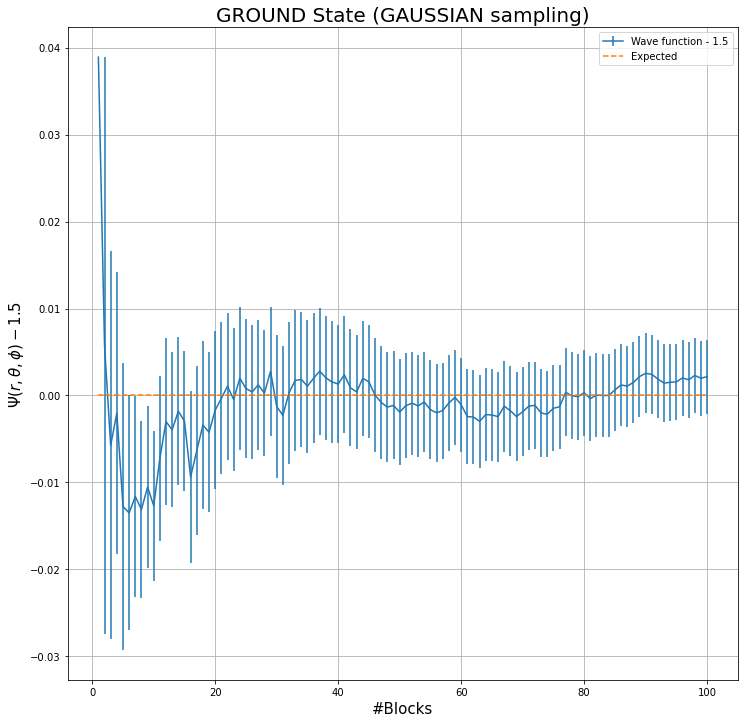

|2,1,0>
Setting starting point to (100, 100, 100)
Acceptance rate: 0.515824

800000 numbers generated
100 blocks
8000 numbers generated per block


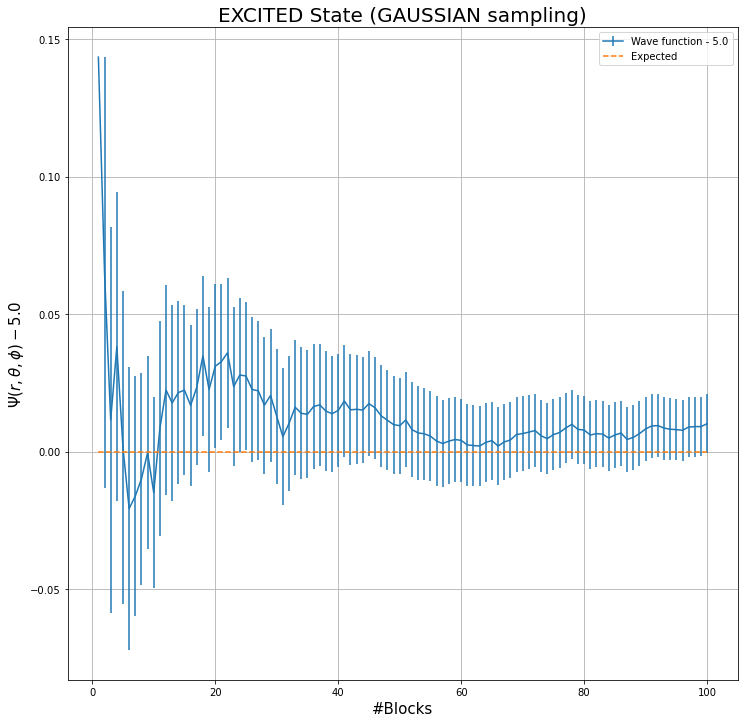

In [99]:
# (1)

startingPosition = [0,0,0]
for i in range(len(states)):
    simulation(8000*100, samplings[1], states[i], results[i], startingPosition, 100000)
    
# (2)
    
startingPosition = [100,100,100]
for i in range(len(states)):
    simulation(8000*100, samplings[1], states[i], results[i], startingPosition, 100000)